# *Second Approach*

## CNN with connected components

Our approach will be, 
* First, to segment the image and identify areas of pneumonia, a convolutional neural network is applied. The bounding boxes generated by the segmentation are used as masks.
* Next, multiple areas of predicted pneumonia are separated using connected components.
* Finally, a bounding box is drawn around each connected component to create a visual representation of the pneumonia regions.

In [1]:
import os
import csv
import random
import pydicom
import numpy as np
import pandas as pd
from skimage import io
from skimage import measure
from skimage.transform import resize

import tensorflow as tf
from tensorflow import keras

from matplotlib import pyplot as plt
import matplotlib.patches as patches

Firstly, we are going to map the filenames with the coordinates of the pneumonia locations. Suppose if a filename has multiple pneumonia locations, it has multiple coordinates. So, with the help of a dictionary, we are going to map it

In [2]:
# empty dictionary
pneumonia_locations = {}
# load table
with open(os.path.join('C:\capstone_data\Pneumonia_Set_Project\stage_2_train_labels.csv'), mode='r') as infile:
    # open reader
    reader = csv.reader(infile)
    # skip header
    next(reader, None)
    # loop through rows
    for rows in reader:
        # retrieve information
        filename = rows[0]
        location = rows[1:5]
        pneumonia = rows[5]
        # if row contains pneumonia add label to dictionary
        # which contains a list of pneumonia locations per filename
        if pneumonia == '1':
            # convert string to float to int
            location = [int(float(i)) for i in location]
            # save pneumonia location in dictionary
            if filename in pneumonia_locations:
                pneumonia_locations[filename].append(location)
            else:
                pneumonia_locations[filename] = [location]

An example to fetch the coordinates of first file

In [3]:
list(pneumonia_locations.values())[0]

[[264, 152, 213, 379], [562, 152, 256, 453]]

#### *Loading the training data again*

In [4]:
# load and shuffle filenames
folder = 'C:\capstone_data\Pneumonia_Set_Project\stage_2_train_images'
filenames = os.listdir(folder)
random.shuffle(filenames)
# split into train and validation filenames
n_valid_samples = 2560
train_filenames = filenames[n_valid_samples:]
valid_filenames = filenames[:n_valid_samples]
print('n train samples', len(train_filenames))
print('n valid samples', len(valid_filenames))
n_train_samples = len(filenames) - n_valid_samples

n train samples 24124
n valid samples 2560


In [5]:
filenames[:2]

['98c1376c-d164-4fdc-ab76-7e68192bb50a.dcm',
 '3cec271b-e1db-4485-b3ab-878da8590082.dcm']

As we had seen in EDA, we have 26684 training images, So we are just going to split into Train-Val split manually roughly a 90-10 split

### As the Dataset is very large, we will need Data Generators

To handle the dataset, which is too extensive to store in memory, we must establish a generator that loads data as needed. The generator accepts file names, batch size, and additional parameters as inputs. Its outputs consist of a random batch of numpy images and numpy masks.

In [6]:
class generator(keras.utils.Sequence):
    
    def __init__(self, folder, filenames, pneumonia_locations=None, batch_size=32, image_size=256, shuffle=True, augment=False, predict=False):
        self.folder = folder
        self.filenames = filenames
        self.pneumonia_locations = pneumonia_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.on_epoch_end()
        
    def __load__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # create empty mask
        msk = np.zeros(img.shape)
        # get filename without extension
        filename = filename.split('.')[0]
        # if image contains pneumonia
        if filename in self.pneumonia_locations:
            # loop through pneumonia
            for location in self.pneumonia_locations[filename]:
                # add 1's at the location of the pneumonia
                x, y, w, h = location
                msk[y:y+h, x:x+w] = 1
        # resize both image and mask
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        msk = resize(msk, (self.image_size, self.image_size), mode='reflect') > 0.5
        # if augment then horizontal flip half the time
        if self.augment and random.random() > 0.5:
            img = np.fliplr(img)
            msk = np.fliplr(msk)
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        msk = np.expand_dims(msk, -1)
        return img, msk
    
    def __loadpredict__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # resize image
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img
        
    def __getitem__(self, index):
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, filenames
        # train mode: return images and masks
        else:
            # load files
            items = [self.__load__(filename) for filename in filenames]
            # unzip images and masks
            imgs, msks = zip(*items)
            # create numpy batch
            imgs = np.array(imgs)
            msks = np.array(msks)
            return imgs, msks
        
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

## *Modelling*

#### We are using IoU loss function, the IoU of a set of predicted bounding boxes and ground truth bounding boxes is calculated as:

In [7]:
# define iou or jaccard loss function
def iou_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1]) 
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score

* Binary cross-entropy (BCE) loss is commonly used as a loss function for binary classification problems, where the goal is to predict whether an input belongs to one of two classes. BCE loss measures the difference between the predicted probability and the actual binary label.

* IOU loss, on the other hand, measures the similarity between the predicted and actual binary masks in object detection or segmentation tasks. IOU loss calculates the overlap between the predicted and actual binary masks and then computes a loss value based on the degree of overlap.

In [8]:
# combine bce loss and iou loss
def iou_bce_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) + 0.5 * iou_loss(y_true, y_pred)

In [9]:
# mean iou as a metric
def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

### *Let us have a brief understanding of what we are going to do*

The network comprises residual blocks with convolutions and downsampling blocks with max pooling. To match the input shape, a sole upsampling layer is employed at the network's end. However, since the input size is reduced to 256 by 256, and the network conducts downsampling multiple times without significant upsampling, the final output is not refined. For instance, if the network downsamples four times, the final bounding boxes can only alter by at least 16 pixels.

In [10]:
def create_downsample(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(x)
    x = keras.layers.MaxPool2D(2)(x)
    return x

def create_resblock(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    return keras.layers.add([x, inputs])

def create_network(input_size, channels, n_blocks=2, depth=4):
    # input
    inputs = keras.Input(shape=(input_size, input_size, 1))
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
    # residual blocks
    for d in range(depth):
        channels = channels * 2
        x = create_downsample(channels, x)
        for b in range(n_blocks):
            x = create_resblock(channels, x)
    # output
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(1, 1, activation='sigmoid')(x)
    outputs = keras.layers.UpSampling2D(2**depth)(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

# Train network


In [11]:
# create network and compiler
model = create_network(input_size=256, channels=32, n_blocks=2, depth=4)
model.compile(optimizer='adam',
              loss=iou_bce_loss,
              metrics=['accuracy', mean_iou])

The function below cosine_annealing defines a learning rate schedule that reduces the learning rate from an initial value of 0.001 to almost zero over a predefined number of epochs (in our case, 25 epochs).

In [12]:
# cosine learning rate annealing
def cosine_annealing(x):
    lr = 0.001
    epochs = 25
    return lr*(np.cos(np.pi*x/epochs)+1.)/2
learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)


In [15]:
# create train and validation generators
folder = 'C:\capstone_data\Pneumonia_Set_Project\stage_2_train_images'
train_gen = generator(folder, train_filenames, pneumonia_locations, batch_size=32, image_size=256, shuffle=True, augment=True, predict=False)
valid_gen = generator(folder, valid_filenames, pneumonia_locations, batch_size=32, image_size=256, shuffle=False, predict=False)

history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate], epochs=10, workers=4, use_multiprocessing=True)

Epoch 1/10
753/753 [==============================] - 576s 765ms/step - loss: 0.4799 - acc: 0.9632 - mean_iou: 0.6103 - val_loss: 0.4956 - val_acc: 0.9578 - val_mean_iou: 0.5705
Epoch 2/10
753/753 [==============================] - 549s 729ms/step - loss: 0.4464 - acc: 0.9674 - mean_iou: 0.6704 - val_loss: 0.5321 - val_acc: 0.9437 - val_mean_iou: 0.5508
Epoch 3/10
753/753 [==============================] - 523s 694ms/step - loss: 0.4375 - acc: 0.9679 - mean_iou: 0.6793 - val_loss: 0.4398 - val_acc: 0.9637 - val_mean_iou: 0.6428
Epoch 4/10
753/753 [==============================] - 525s 698ms/step - loss: 0.4300 - acc: 0.9691 - mean_iou: 0.6895 - val_loss: 0.4849 - val_acc: 0.9426 - val_mean_iou: 0.4711
Epoch 5/10
753/753 [==============================] - 525s 697ms/step - loss: 0.4264 - acc: 0.9695 - mean_iou: 0.6935 - val_loss: 0.4912 - val_acc: 0.9609 - val_mean_iou: 0.6013
Epoch 6/10
753/753 [==============================] - 523s 695ms/step - loss: 0.4200 - acc: 0.9702 - mean_iou:

In [23]:
print(train_gen)

### *Plotting Loss, Accuracy & IoU*

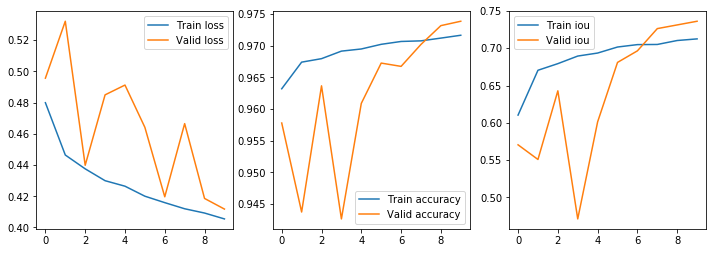

In [16]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["acc"], label="Train accuracy")
plt.plot(history.epoch, history.history["val_acc"], label="Valid accuracy")
plt.legend()
plt.subplot(133)
plt.plot(history.epoch, history.history["mean_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_mean_iou"], label="Valid iou")
plt.legend()
plt.show()

### Batch Prediction

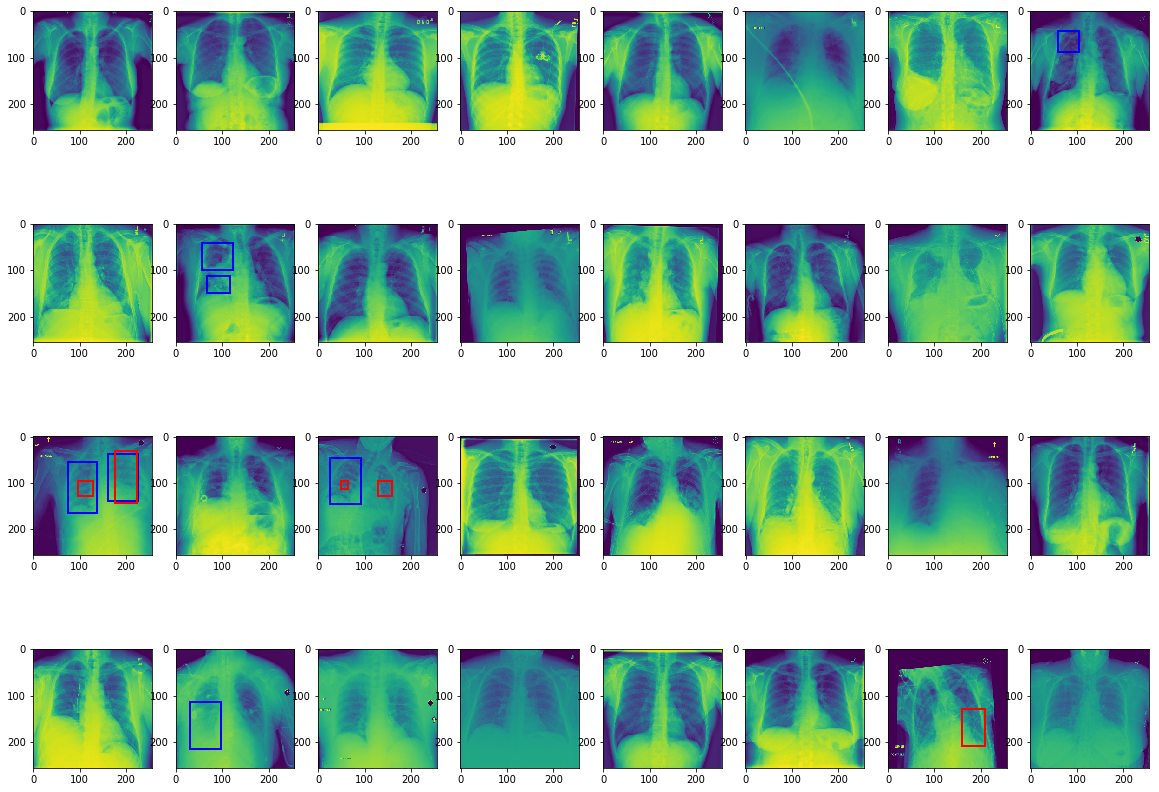

In [20]:
for imgs, msks in valid_gen:
    # predict batch of images
    preds = model.predict(imgs)
    # create figure
    f, axarr = plt.subplots(4, 8, figsize=(20,15))
    axarr = axarr.ravel()
    axidx = 0
    # loop through batch
    for img, msk, pred in zip(imgs, msks, preds):
        # plot image
        axarr[axidx].imshow(img[:, :, 0])
        # threshold true mask
        comp = msk[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='b',facecolor='none'))
        # threshold predicted mask
        comp = pred[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='r',facecolor='none'))
        axidx += 1
    plt.show()
    # only plot one batch
    break

# Predicting on test images

In [19]:
# load and shuffle filenames
folder = 'C:\capstone_data\Pneumonia_Set_Project\stage_2_test_images'
test_filenames = os.listdir(folder)
print('n test samples:', len(test_filenames))

# create test generator with predict flag set to True
test_gen = generator(folder, test_filenames, None, batch_size=25, image_size=256, shuffle=False, predict=True)

# create submission dictionary
submission_dict = {}
# loop through testset
for imgs, filenames in test_gen:
    # predict batch of images
    preds = model.predict(imgs)
    # loop through batch
    for pred, filename in zip(preds, filenames):
        # resize predicted mask
        pred = resize(pred, (1024, 1024), mode='reflect')
        # threshold predicted mask
        comp = pred[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            # proxy for confidence score
            conf = np.mean(pred[y:y+height, x:x+width])
            # add to predictionString
            predictionString += str(conf) + ' ' + str(x) + ' ' + str(y) + ' ' + str(width) + ' ' + str(height) + ' '
        # add filename and predictionString to dictionary
        filename = filename.split('.')[0]
        submission_dict[filename] = predictionString
    # stop if we've got them all
    if len(submission_dict) >= len(test_filenames):
        break

# save dictionary as csv file
sub = pd.DataFrame.from_dict(submission_dict,orient='index')
sub.index.names = ['patientId']
sub.columns = ['PredictionString']
sub.to_csv('submission.csv')

n test samples: 3000


In [22]:
for imgs, filenames in valid_gen:
    print(imgs, filenames)
    break

[[[[2.54901961e-02]
   [2.35294118e-02]
   [2.35294118e-02]
   ...
   [1.17647059e-02]
   [3.92156863e-02]
   [9.99019608e-01]]

  [[2.54901961e-02]
   [2.35294118e-02]
   [2.35294118e-02]
   ...
   [1.17647059e-02]
   [2.64705882e-02]
   [9.97058824e-01]]

  [[2.54901961e-02]
   [2.35294118e-02]
   [2.35294118e-02]
   ...
   [7.84313725e-03]
   [3.33333333e-02]
   [1.00000000e+00]]

  ...

  [[4.80392157e-02]
   [4.11764706e-02]
   [4.31372549e-02]
   ...
   [5.78431373e-02]
   [8.92156863e-02]
   [1.37254902e-01]]

  [[6.86274510e-02]
   [6.66666667e-02]
   [6.47058824e-02]
   ...
   [8.33333333e-02]
   [1.22549020e-01]
   [1.84313725e-01]]

  [[9.90196078e-02]
   [9.80392157e-02]
   [9.70588235e-02]
   ...
   [1.23529412e-01]
   [1.68627451e-01]
   [2.39215686e-01]]]


 [[[9.69607843e-01]
   [9.45098039e-01]
   [9.30392157e-01]
   ...
   [9.73529412e-01]
   [9.86274510e-01]
   [9.92156863e-01]]

  [[9.01960784e-01]
   [8.86274510e-01]
   [8.72549020e-01]
   ...
   [9.14705882e-01]
 